In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Pendulum-v2')

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g


def gradient_for_one_data(state, next_state, actor, critic):
    params = actor.trainable_weights  
    # q_func gradient tensor
    state_input = tf.constant([[state.tolist()]], tf.float32)
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.constant([[next_state.tolist()]], tf.float32)
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    gradient_for_one_state = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    return gradient_for_one_state

def gradient(states, ts, next_states, actor, critic):
    batch_size = len(states)
    for i in range(batch_size):
        state, t, next_state = states[i], ts[i], next_states[i]
        discount = np.exp(- alpha * t)
        g_tensor = gradient_for_one_data(state, next_state, actor, critic)
        g_tensor = [discount * g for g in g_tensor]
        if i == 0:
            out = [tf.constant(0.)] * len(g_tensor)
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
        else:
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
    func = K.function([], out)
    gg = func([[]])
    return gg

# Adam クラス
def learning_rate_arr(actor, size=210, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(210,) # 前回の勾配
        self.v = np.zeros(210,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [5]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    batch_size = 32
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    tmp = []
    for i in range(len(log) - 1):
        tmp.append([log[i][0], log[i][1], log[i+1][0]])
    tmp = np.array(tmp)
    states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
    pg = gradient(states, ts, next_states, actor, critic)
    pg = flatten_gradient(pg)
    return pg

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward

In [6]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [7]:
actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
critic.load_weights('../saved_agent/learned_self_clipped_critic_l.h5')
target_actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
target_critic.load_weights('../saved_agent/learned_self_clipped_critic_l.h5')
lrs = learning_rate_arr(actor, size=210, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)

In [ ]:
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)#, epoch=int(5000//(1+np.sqrt(i-1))))
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -45.7514198778051
1-step
loss of critic is 2.31201171875, value_fuction V(s) = -48.77297398978032
|g| = 163.1171194236443
2-step
loss of critic is 2.112069606781006, value_fuction V(s) = -48.81870177850103
|g| = 258.1651511212866
3-step
loss of critic is 2.3116652965545654, value_fuction V(s) = -46.013444102035706
|g| = 227.59013664524068
4-step
loss of critic is 1.9170640707015991, value_fuction V(s) = -41.45291184068161
|g| = 304.7117693033294
5-step
loss of critic is 1.9022495746612549, value_fuction V(s) = -44.96400356643018
|g| = 146.92324193328832
6-step
loss of critic is 1.737808346748352, value_fuction V(s) = -44.7705649510652
|g| = 212.57284982258653
7-step
loss of critic is 1.5895802974700928, value_fuction V(s) = -42.31361052415374
|g| = 594.7097287884684
8-step
loss of critic is 1.3872570991516113, value_fuction V(s) = -42.89571011024868
|g| = 211.5175107339342
9-step
loss of critic is 1.3939259052276611, value_fuction V(s) = -42.52066413

In [33]:
env.reset()
actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    states.append(env.state)
    episode_reward += np.exp(- alpha * acc_time) * reward
    acc_time += tau
    time_log.append(acc_time)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

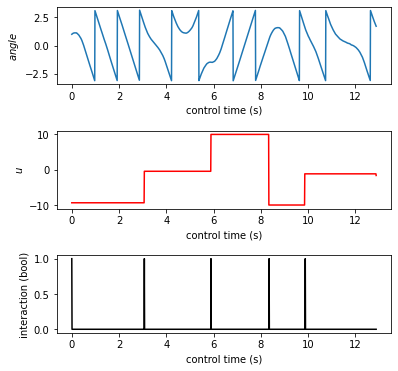

In [34]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$angle$')
plt.plot(detail_time_log, detail_states[:,0])
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [35]:
episode_reward

-45.90706457709063

In [32]:
actor.save_weights('../saved_agent/learned_self_ideal0_actor.h5')
critic.save_weights('../saved_agent/learned_self_ideal0_critic.h5')

In [36]:
# 逆にいうたらここからあれが学習できてるのすごくね

In [5]:
sr = '''
loss of critic is 2.4034640789031982, value_fuction V(s) = -48.34495463392813
|g| = 104.85513398347709
2-step
loss of critic is 2.165095806121826, value_fuction V(s) = -45.23643011663504
|g| = 193.42441342914975
3-step
loss of critic is 2.279160976409912, value_fuction V(s) = -42.85002771078124
|g| = 217.9167518300407
4-step
loss of critic is 1.7402913570404053, value_fuction V(s) = -46.772182537538185
|g| = 225.01527179103596
5-step
loss of critic is 1.6377042531967163, value_fuction V(s) = -42.63635775549192
|g| = 179.10935190293918
6-step
loss of critic is 1.402305245399475, value_fuction V(s) = -45.1562601950994
|g| = 128.08218674761386
7-step
loss of critic is 1.4234066009521484, value_fuction V(s) = -39.70436260237461
|g| = 375.0961764393257
8-step
loss of critic is 1.314547061920166, value_fuction V(s) = -36.42161336829346
|g| = 332.98683226422634
9-step
loss of critic is 1.3594707250595093, value_fuction V(s) = -35.37303517631027
|g| = 190.11768523126008
10-step
loss of critic is 1.541351079940796, value_fuction V(s) = -37.130559890695146
|g| = 190.80818129802057
11-step
loss of critic is 1.374525785446167, value_fuction V(s) = -45.640136598261996
|g| = 312.6488760162822
12-step
loss of critic is 1.3270511627197266, value_fuction V(s) = -32.63100303136204
|g| = 181.20003324358714
13-step
loss of critic is 1.1378527879714966, value_fuction V(s) = -28.83189616341518
|g| = 461.9933491316485
14-step
loss of critic is 1.0615977048873901, value_fuction V(s) = -39.56981494004489
|g| = 358.2985871354086
15-step
loss of critic is 1.1453533172607422, value_fuction V(s) = -32.27994839756064
|g| = 351.3861885539922
16-step
loss of critic is 1.2130481004714966, value_fuction V(s) = -34.30296645342437
|g| = 360.8967223132913
17-step
loss of critic is 1.2193751335144043, value_fuction V(s) = -40.17352309163446
|g| = 444.2895185676264
18-step
loss of critic is 1.2575972080230713, value_fuction V(s) = -29.234548443156818
|g| = 1112.2483566701578
19-step
loss of critic is 1.2427386045455933, value_fuction V(s) = -31.758501313264144
|g| = 395.166088193388
20-step
loss of critic is 1.2201683521270752, value_fuction V(s) = -37.661963572098614
|g| = 218.6576076860278
21-step
loss of critic is 1.2438818216323853, value_fuction V(s) = -29.252892774901916
|g| = 371.1843764058676
22-step
loss of critic is 1.2586970329284668, value_fuction V(s) = -33.283577689189364
|g| = 191.63282621198718
23-step
loss of critic is 1.2544187307357788, value_fuction V(s) = -36.62548604489417
|g| = 844.4850175867757
24-step
loss of critic is 1.2825055122375488, value_fuction V(s) = -27.05455583138489
|g| = 537.2945140234028
25-step
loss of critic is 1.2165207862854004, value_fuction V(s) = -26.959039524300987
|g| = 571.497253613298
26-step
loss of critic is 1.273073673248291, value_fuction V(s) = -37.57328538932213
|g| = 408.9417330821313
27-step
loss of critic is 1.3353378772735596, value_fuction V(s) = -32.80401433263864
|g| = 322.1005290751681
28-step
loss of critic is 1.300024390220642, value_fuction V(s) = -27.613122698279916
|g| = 443.7281312495109
29-step
loss of critic is 1.3320294618606567, value_fuction V(s) = -31.341259338177263
|g| = 436.54018884498595
30-step
loss of critic is 1.4312738180160522, value_fuction V(s) = -33.02470039909559
|g| = 362.1464253049292
31-step
loss of critic is 1.3971422910690308, value_fuction V(s) = -43.33513653858631
|g| = 438.0933291299749
32-step
loss of critic is 1.429640293121338, value_fuction V(s) = -45.104862784839675
|g| = 328.4117078123017
33-step
loss of critic is 1.5554049015045166, value_fuction V(s) = -37.96213014797369
|g| = 914.5782946017217
34-step
loss of critic is 1.6460835933685303, value_fuction V(s) = -42.81823183492746
|g| = 589.2529028272472
35-step
loss of critic is 1.7143480777740479, value_fuction V(s) = -31.600082397082716
|g| = 722.0861174280258
36-step
loss of critic is 1.586704134941101, value_fuction V(s) = -36.27300987570056
|g| = 407.48244404441266
37-step
loss of critic is 1.7482062578201294, value_fuction V(s) = -46.20865110063582
|g| = 780.3998585019893
38-step
loss of critic is 1.625964879989624, value_fuction V(s) = -34.088989303754296
|g| = 685.372107763986
39-step
loss of critic is 1.5094196796417236, value_fuction V(s) = -19.688591589359195
|g| = 538.0812957714188
40-step
loss of critic is 1.5625883340835571, value_fuction V(s) = -17.137063033464198
|g| = 1909.710592178338
41-step
loss of critic is 1.7600855827331543, value_fuction V(s) = -18.148739592343375
|g| = 2308.143503798202
42-step
loss of critic is 1.6157325506210327, value_fuction V(s) = -19.285658859138884
|g| = 2602.257330172622
43-step
loss of critic is 1.5423496961593628, value_fuction V(s) = -20.7058252159552
|g| = 2437.0979265635146
44-step
loss of critic is 1.3918815851211548, value_fuction V(s) = -22.351165912220136
|g| = 2250.5372773231747
45-step
loss of critic is 1.412566065788269, value_fuction V(s) = -24.064513097447417
|g| = 1685.9471951001578
46-step
loss of critic is 1.446967601776123, value_fuction V(s) = -25.95760880528172
|g| = 1442.05449555446
47-step
loss of critic is 1.299756646156311, value_fuction V(s) = -27.805467823315144
|g| = 1631.7127690866841
48-step
loss of critic is 1.178297996520996, value_fuction V(s) = -29.844611008149908
|g| = 1579.821720817482
49-step
loss of critic is 1.291690468788147, value_fuction V(s) = -32.18725104173901
|g| = 1608.7669410804276
50-step
loss of critic is 1.2553603649139404, value_fuction V(s) = -34.4499082819048
|g| = 1447.0170488982017
51-step
loss of critic is 1.210402488708496, value_fuction V(s) = -36.64361468333571
|g| = 1087.2956945201308
52-step
loss of critic is 1.185543417930603, value_fuction V(s) = -38.78517797728749
|g| = 564.2252954615922
53-step
loss of critic is 1.2519654035568237, value_fuction V(s) = -41.248004436069394
|g| = 107.22764174595765
54-step
loss of critic is 1.3550245761871338, value_fuction V(s) = -43.573633070948574

'''

In [6]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

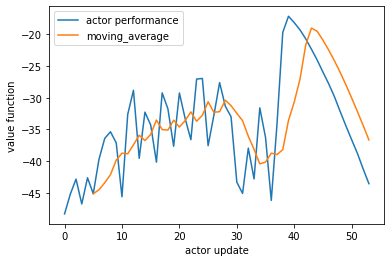

In [7]:
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()